# Парный трейдинг: сигналы по пересечению средних

Сократим количество ложных сигналов, сгладив сигнальную
линию скользящими средними SMA10 и SMA50.

Сделать функцию, которую можно перенести в поиск, для
получения дополнительного параметра количества сигналов.

In [45]:
%matplotlib inline
import operator
import talib
import numpy as np
import pandas as pd
import time
from datetime import datetime, date, timedelta

import statsmodels
from statsmodels.tsa.stattools import adfuller

import seaborn
import matplotlib.pyplot as plt

from db import (db, prices, get_performance, 
                prepare_pair, get_prices_yahoo, months_generator)

pd.set_option('display.max_rows', 500) # default 30
pd.set_option('display.max_columns', 80) # default 20
pd.set_option('max_colwidth', 100) # default 40

def zscore_std(series, name="z-score"):
    return ((series - series.mean()) / np.std(series)).rename(name)

def zscore_std_np(a):
    b = (a - a.mean()) / np.std(a)
    b[np.isnan(b)] = 0
    return b

def z_score_ma(spread, short=10, long=60, name="z-ma"):    
    # Получаем разницу цен двух наборов данных
    difference = spread
    difference.name = 'diff'

    # Получаем 10-дневную скользящую среднюю от разницы
    diff_mavg_short = difference.rolling(window=short, center=False).mean()
    diff_mavg_short.name = 'diff {0}d mavg'.format(short)

    # Получаем 60-дневную скользящую среднюю от разницы
    diff_mavg_long = difference.rolling(window=long, center=False).mean()
    diff_mavg_long.name = 'diff {0}d mavg'.format(long)
    
    # Получаем скользящее 60-дневное стандартное отклонение
    std_long = difference.rolling(center=False, window=long).std()
    std_long.name = 'std {0}d'.format(long)

    # Рассчитываем z-оценку на каждый день
    zscore = (diff_mavg_short - diff_mavg_long)/std_long
    zscore.name = (name + ' {0}d/{1}d').format(short, long)

    return zscore

In [46]:
def get_diff(y):
    """
    Метод наименьших квадратов
    для поиска разницы между парами.
    """
    x = np.array([i for i in range(len(y))])
    arr = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(arr, y)[0]
    #print(m, c)
    return c

In [47]:
analyze_length = 370
analyze_date = datetime(2016, 1, 1)
pair = ('CIT', 'STT')

symbol_list = pair
all_prices = prices(list(symbol_list), analyze_date, analyze_length)
symbol_test_prices = {s: np.array([x[5] for x in all_prices if x[0] == s]) for s in symbol_list}
symbol_dates = {s: np.array([x[1] for x in all_prices if x[0] == s]) for s in symbol_list}

pair

('CIT', 'STT')

Score=-6.0656; P-value=0.0000; Cointegrated=True; Crit[5%]=-2.8730 
Spread mean=1.40650; Spread median=1.56623; Percentile 80%=2.04026;


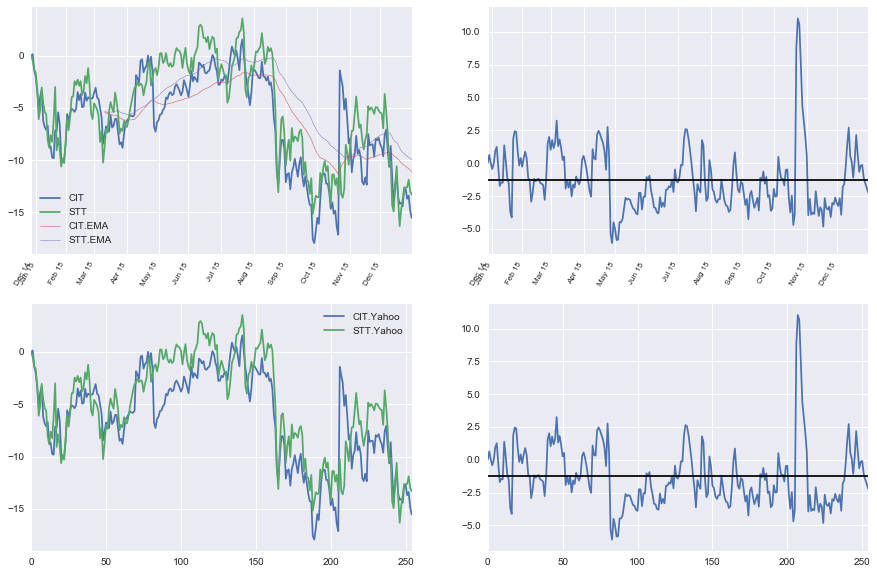

In [48]:
S1 = symbol_test_prices[pair[0]]
S2 = symbol_test_prices[pair[1]]

length_limit = min(len(S1), len(S2))

yprices = get_prices_yahoo([pair[0], pair[1]], dt_end=analyze_date)
Y1 = yprices[pair[0]].as_matrix()[-length_limit:]
Y2 = yprices[pair[1]].as_matrix()[-length_limit:]

# подготавливаем ряды
X, Y = prepare_pair(S1, S2, to_performance=True)
YX, YY = prepare_pair(Y1, Y2, to_performance=True)

period = 50
ema1 = talib.EMA(X, timeperiod=period)
ema2 = talib.EMA(Y, timeperiod=period)

# расчеты
diff = (ema1[period-1:] - ema2[period-1:])
diff_mean = abs(diff).mean()
diff_median = np.median(abs(diff))
diff_percentile = np.percentile(abs(diff), 80)

# prepare charts
X = pd.Series(X, name=pair[0])
Y = pd.Series(Y, name=pair[1])
YX = pd.Series(YX, name=pair[0] + '.Yahoo')
YY = pd.Series(YY, name=pair[1] + '.Yahoo')
X_ema = pd.Series(ema1, name=pair[0] + '.EMA')
Y_ema = pd.Series(ema2, name=pair[1] + '.EMA')

# xticks
dates = symbol_dates[pair[0]][-len(X):]
months = list(months_generator(dates))
xticks = [i for i in range(0, len(X)) if dates[i] in months]
xticklabels = [dt.strftime('%b %y') for dt in months]

# draw performance and MAs
fig, axs = plt.subplots(2,2, figsize=(15, 10))
pd.concat([X, Y], axis=1).plot(xticks=xticks, ax=axs[0][0]) # Performance
pd.concat([X_ema, Y_ema], axis=1).plot(ax=axs[0][0], linewidth=0.5) # SMA50
# xtick labels
axs[0][0].set_xticklabels(xticklabels, size=8, rotation=60, ha='right')

# draw spread
diff_series = pd.Series(X - Y, name='-'.join(pair))
diff_series.plot(xticks=xticks, ax=axs[0][1])
axs[0][1].axhline(diff_series.mean(), color='black')
# xtick labels
axs[0][1].set_xticklabels(xticklabels, size=8, rotation=60, ha='right')

# Yahoo.Finance for comparison
pd.concat([YX, YY], axis=1).plot(ax=axs[1][0]) # Performance
Ydiff_series = pd.Series(YX - YY, name='-'.join(pair))
Ydiff_series.plot(ax=axs[1][1])
axs[1][1].axhline(Ydiff_series.mean(), color='black')

result = adfuller(X-Y)
score, pvalue, crit = result[0], result[1], result[4]
print(
    'Score={0:.4f}; P-value={1:.4f}; Cointegrated={2}; Crit[5%]={3:.4f}'.format(score, pvalue, score < crit['5%'], crit['5%']),
    '\nSpread mean={0:.5f}; Spread median={1:.5f}; Percentile 80%={2:.5f};'.format(diff_mean, diff_median, diff_percentile)
)

(255,)

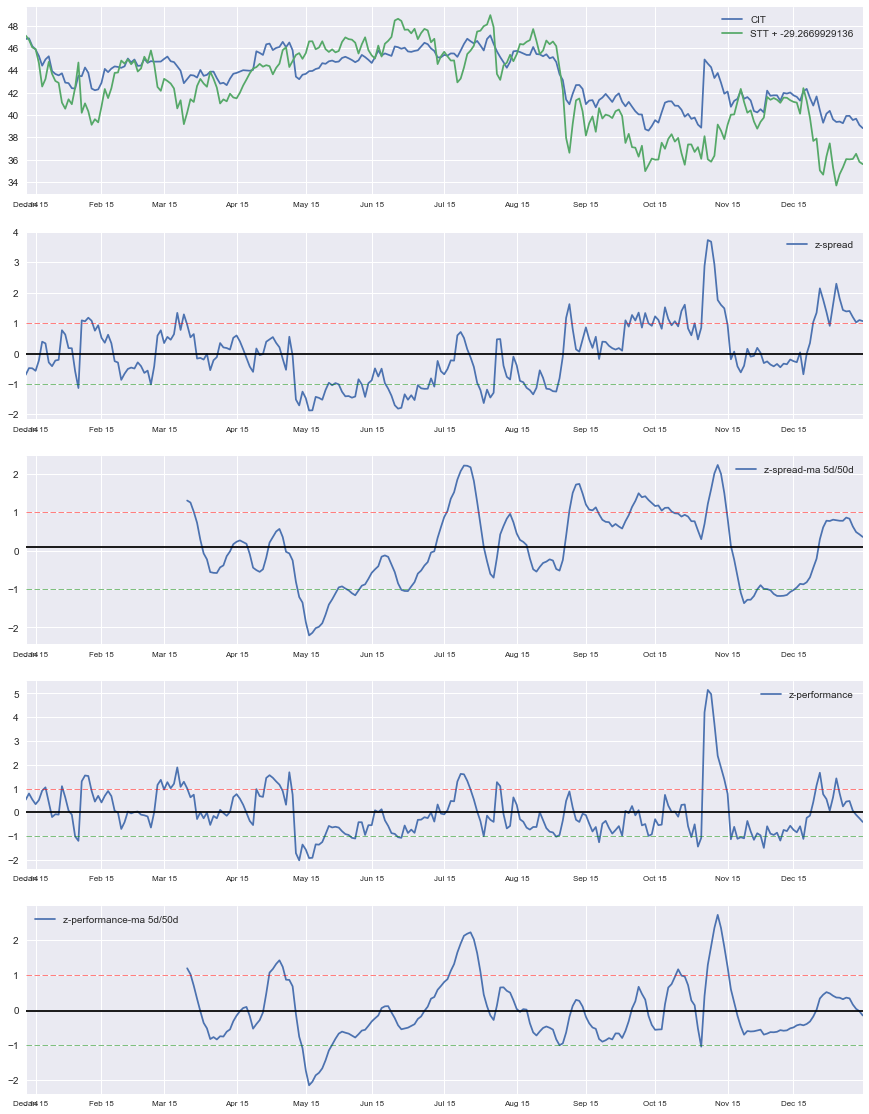

In [49]:
# Draw prices with z-score 
P1, P2 = prepare_pair(S1, S2, to_performance=False)

assets_diff = get_diff(P1 - P2)

coef_idx = -1 # 0/-1
ratio = S1[coef_idx]/S2[coef_idx]
P1 = pd.Series(P1, name=pair[0]) # приводим к одной цене по первому отношению
#P2 = pd.Series(P2, name=pair[1] + ' x ' + str(ratio))
P2 = pd.Series(P2, name=pair[1] + ' + ' + str(assets_diff))

# convert to same price
P2 = P2 + assets_diff

fig, axs = plt.subplots(5, 1, figsize=(15, 20))
# change background
fig.set_facecolor('white')

# рисуем оба ряда
pd.concat([P1, P2], axis=1).plot(xticks=xticks, ax=axs[0]) 

# xtick labels
axs[0].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

def draw_signal(series, axs):
    series.plot(xticks=xticks, ax=axs, legend=True)
    axs.axhline(series.mean(), color='black')
    axs.axhline(1.0, color='red', linestyle='--', linewidth=0.5)
    axs.axhline(-1.0, color='green', linestyle='--', linewidth=0.5)
    # xtick labels
    axs.set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

# price spread
diff_series = P1 - P2
draw_signal(zscore_std(diff_series, name="z-spread"), axs[1])

# z-score by MA cross
draw_signal(z_score_ma(diff_series, short=5, long=50, name="z-spread-ma"), axs[2])

# performance spread
Perf1, Perf2 = prepare_pair(S1, S2, to_performance=True)
Perf1 = pd.Series(Perf1, name=pair[0])
Perf2 = pd.Series(Perf2, name=pair[1])
draw_signal(zscore_std(Perf1 - Perf2, name="z-performance"), axs[3])

# z-score by MA cross
draw_signal(z_score_ma(Perf1 - Perf2, short=5, long=50, name="z-performance-ma"), axs[4])

P1.shape

In [68]:
# Считаем кол-во пересечений

z = zscore_std(diff_series, name="z-spread")
z = z_score_ma(diff_series, short=5, long=50, name="z-spread-ma")
z = zscore_std(Perf1 - Perf2, name="z-performance")
z = z_score_ma(Perf1 - Perf2, short=5, long=50, name="z-performance-ma")
res = dict()
res['x(0)'] = len(z[abs(np.insert(np.diff(np.sign(z)), 0, 0)) == 2])
res['x(-1)'] = len(z[abs(np.insert(np.diff(np.sign(z+1)), 0, 0)) == 2]) 
res['x(+1)'] = len(z[abs(np.insert(np.diff(np.sign(z-1)), 0, 0)) == 2])
res

{'x(+1)': 9, 'x(-1)': 6, 'x(0)': 23}

## Сглаживаем спред скользящими средними

В основе используем спред цен двух активов.

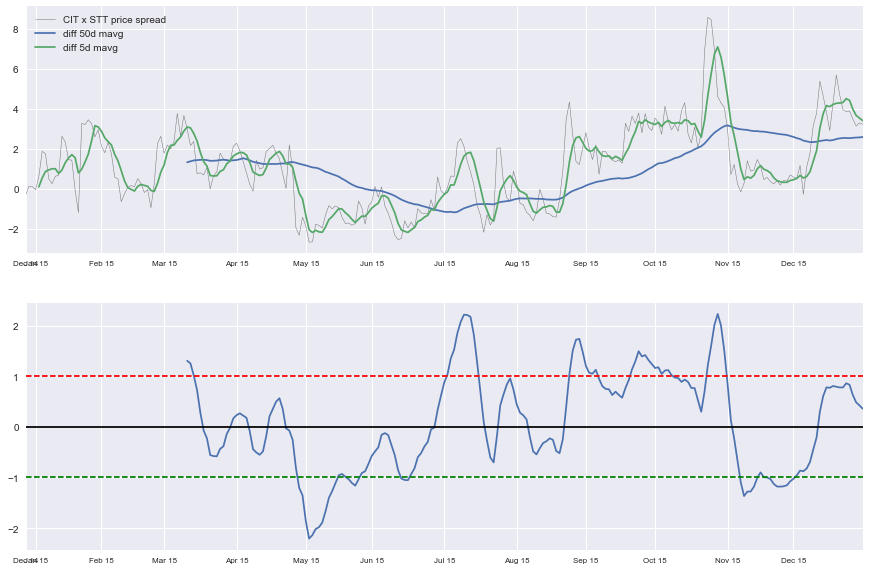

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
# change background
fig.set_facecolor('white')

# xtick labels
axs[0].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')
axs[1].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

# рисуем спред цен
(P1 - P2).rename('{0} x {1} price spread'.format(pair[0], pair[1])).plot(ax=axs[0], color="black", linewidth=0.5, alpha=0.5, legend=True)

# Получаем разницу цен двух наборов данных
difference = P1 - P2
difference.name = 'diff'

# Получаем 10-дневную скользящую среднюю от разницы
diff_mavg10 = difference.rolling(window=5, center=False).mean()
diff_mavg10.name = 'diff 5d mavg'

# Получаем 60-дневную скользящую среднюю от разницы
diff_mavg60 = difference.rolling(window=50, center=False).mean()
diff_mavg60.name = 'diff 50d mavg'

pd.concat([diff_mavg60, diff_mavg10], axis=1).plot(xticks=xticks, ax=axs[0])

z_score_ma(diff_series, short=5, long=50).plot(xticks=xticks, ax=axs[1])
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')


# Код алгоритма Quantopian

Это полноценный код алгортим. Скопировал, вставил.

In [7]:
"""
Парный трейдинг. Уменьшенные таймфреймы: 1 час, 30 мин, 15 мин.

# 2016: EQY, T; DIA, SLB; E, MMP;
# 2015: DRE, O; CIT, STT; TLT, VNQ; PNR, FDX;
# 2014-2015: DRE, O; H, MMP; CMS, SPG;
    
# 2014: SMH, SSO
    
"""
import talib
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller


# подготовка теста
def initialize(context):
    # пара
    context.pair = [
        symbol('CIT'),
        symbol('STT')        
    ] 

# ежедневная проверка сигналов
def handle_data(context, data):
    # check time
    dt = get_datetime()
    # run every hour - dt.minute in [59]
    # run every 30 minutes - dt.minute in [59, 29]
    # run every 15 minutes - dt.minute in [59, 14, 29, 44]
    if dt.minute not in [59]:        
        return
    
    stocks = context.pair
    
    can_trade = data.can_trade(stocks)
    
    # выходим, если не можем торговать одной из акций
    for stock in stocks:
        if not can_trade[stock]:
            log.warn("Can't trade " + stock.symbol)
            return
    
    # загрузка исторических данных
    hist = data.history(stocks, ['close'], 500, '1d')
    hist_min = data.history(stocks, ['close'], 6000, '1m')

    tf = 'H'  # hour
    #tf = '30T'  # 30 minutes
    #tf = '15T'  # 15 minutes
    hist_small = dict()
    for stock in stocks:
        hist_small[stock] = hist_min['close'][stock].resample(tf).last().dropna()
    
    # переводим в относительные значения
    check_length = 120
    performance = [
        get_performance(hist['close'][stocks[0]][-check_length:].as_matrix()),
        get_performance(hist['close'][stocks[1]][-check_length:].as_matrix())
    ]    
    spread_performance = pd.Series(performance[0] - performance[1])
    
    # small timeframe
    perf_small = [
        get_performance(hist_small[stocks[0]][-check_length:].as_matrix()),
        get_performance(hist_small[stocks[1]][-check_length:].as_matrix())
    ]
    spread_perf_small = pd.Series(perf_small[0] - perf_small[1])
    
    spread = spread_performance  # для проверки стационарности
    zscore = zscore_std(spread)  # standard
    #zscore = z_score_ma(spread, short=5, long=50)  # ma
    
    #zscore = zscore_std(spread_perf_small)  # standard small
    #zscore = z_score_ma(spread_perf_small, short=5, long=50)  # ma small
    
    # сигнал
    z = zscore.iloc[-1]
    
    if len(spread[-check_length:].dropna()) < check_length:
        log.warn("Can't trade with short length")
        return
    
    # проверка стационарности
    result = adfuller(spread.iloc[-check_length:])
    score, pvalue, crit = result[0], result[1], result[4]
    coint = score < crit['5%']
    #coint = True  # проверка отключена
    
    if not coint:
        # если пропала стационарность, закрываемся
        order_target_percent(stocks[0], 0)
        order_target_percent(stocks[1], 0)
    elif z > 1:
        # если опережает акция А
        order_target_percent(stocks[0], -1)
        order_target_percent(stocks[1], 1)
    elif z < -1:
        # если опережает акция Б
        order_target_percent(stocks[0], 1)
        order_target_percent(stocks[1], -1)
    elif abs(z) < 0.05:
        # рядом с нулем закрываем позицию
        order_target_percent(stocks[0], 0)
        order_target_percent(stocks[1], 0)
    
    # собираем историю значений
    sign = abs(z) / z if z else 0
    record(**{
            'zscore': z if abs(z) <= 2.05 else sign*2.05,
            'z-perf': zscore_std(spread_performance).iloc[-1],
            stocks[0].symbol: context.portfolio.positions[stocks[0]].amount,
            stocks[1].symbol: context.portfolio.positions[stocks[1]].amount
          })

def zscore_std(series):
    return (series - series.mean()) / np.std(series)

def z_score_ma(spread, short=10, long=60, name="z-ma"):    
    # Получаем разницу цен двух наборов данных
    difference = spread
    difference.name = 'diff'

    # Получаем 10-дневную скользящую среднюю от разницы
    diff_mavg_short = difference.rolling(window=short, center=False).mean()
    diff_mavg_short.name = 'diff {0}d mavg'.format(short)

    # Получаем 60-дневную скользящую среднюю от разницы
    diff_mavg_long = difference.rolling(window=long, center=False).mean()
    diff_mavg_long.name = 'diff {0}d mavg'.format(long)
    
    # Получаем скользящее 60-дневное стандартное отклонение
    std_long = difference.rolling(center=False, window=long).std()
    std_long.name = 'std {0}d'.format(long)

    # Рассчитываем z-оценку на каждый день
    zscore = (diff_mavg_short - diff_mavg_long)/std_long
    zscore.name = (name + ' {0}d/{1}d').format(short, long)

    return zscore

def get_performance(a):
    """
    Convert vector to performance
    """
    a = a.round(2)
    return np.insert(np.cumsum(np.diff(a) / a[:-1] * 100.), 0, 0)

def get_diff(y):
    # Метод наименьших квадратов
    x = np.array([i for i in range(len(y))])
    arr = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(arr, y)[0]
    #print(m, c)
    return c